In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 10

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

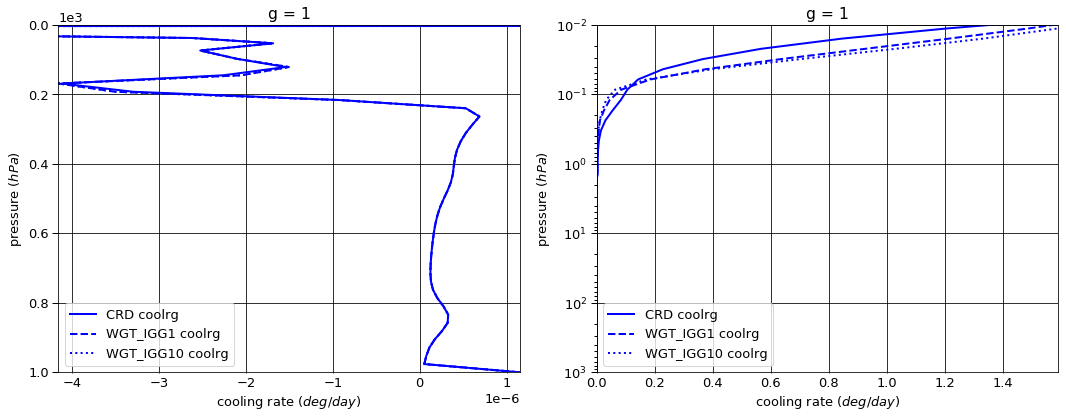

# Figure: cooling rate g-group 2

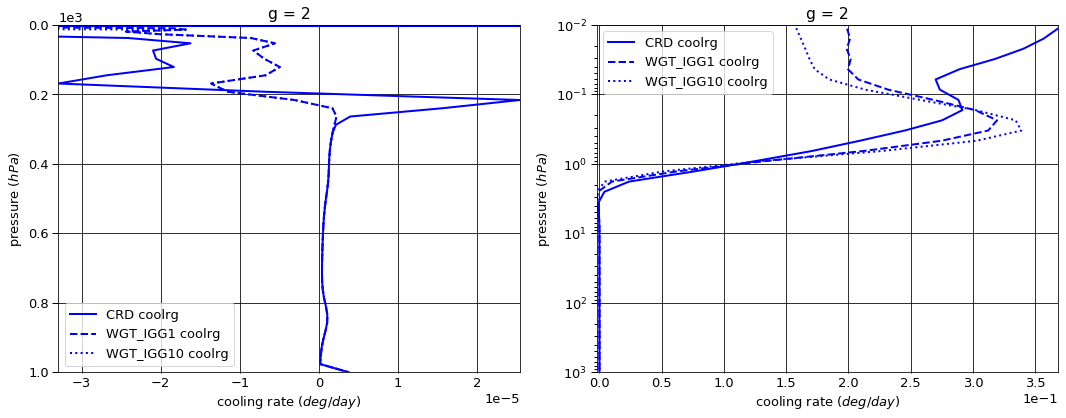

# Figure: cooling rate g-group 3

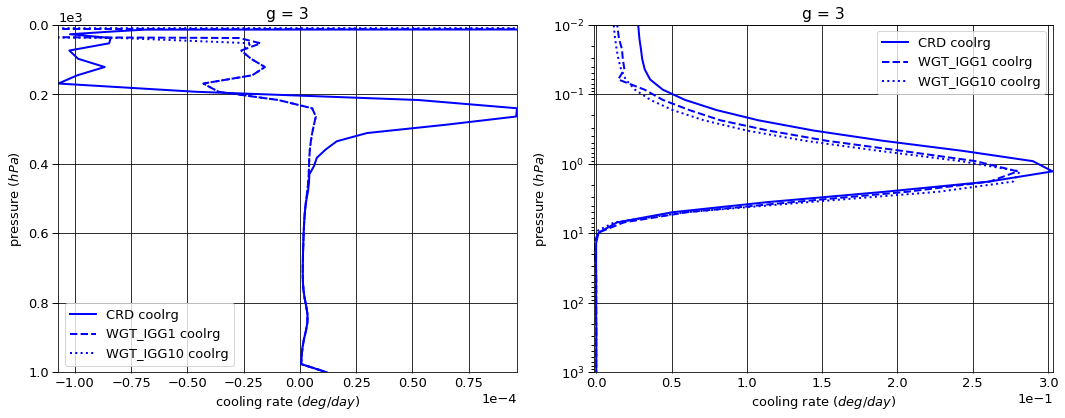

# Figure: cooling rate g-group 4

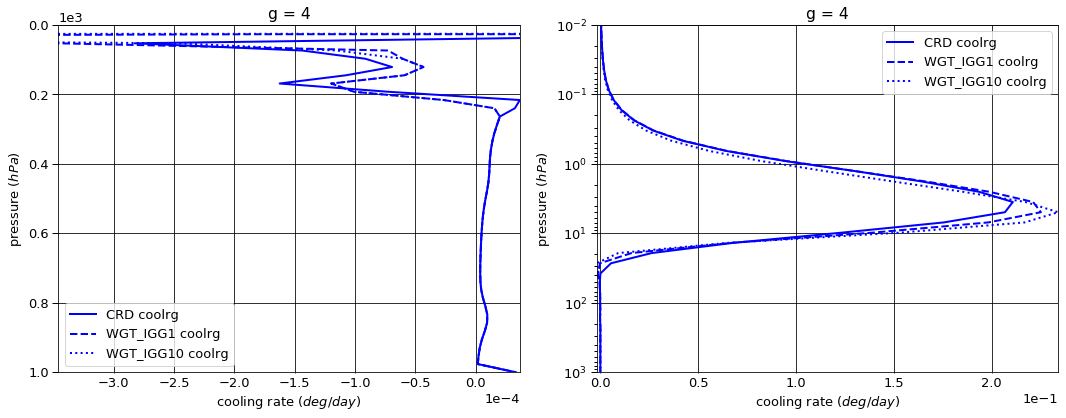

# Figure: cooling rate g-group 5

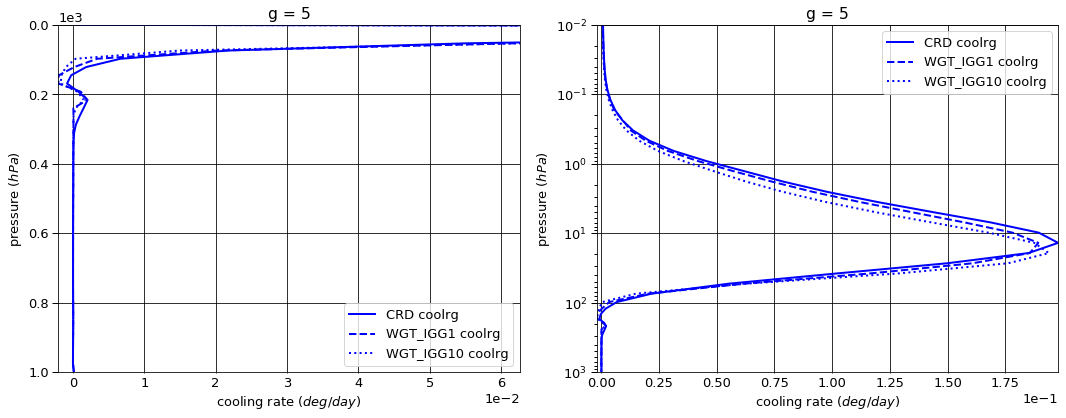

# Figure: cooling rate g-group 6

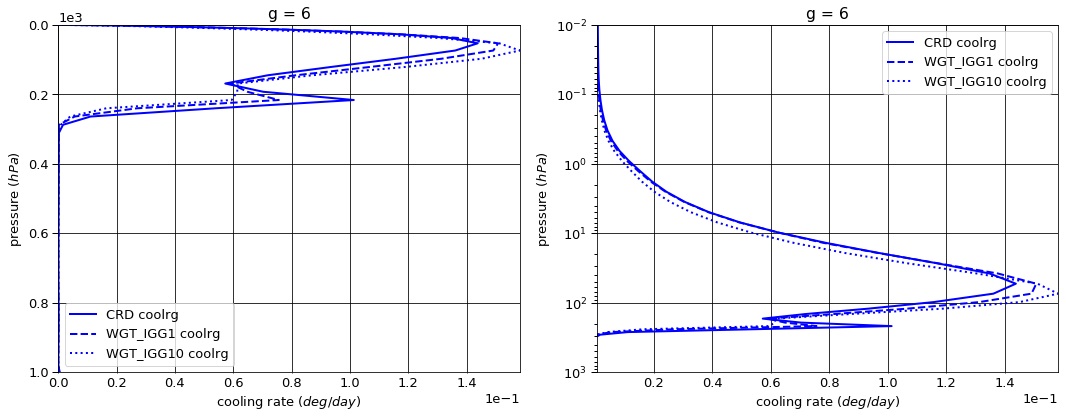

# Figure: cooling rate g-group 7

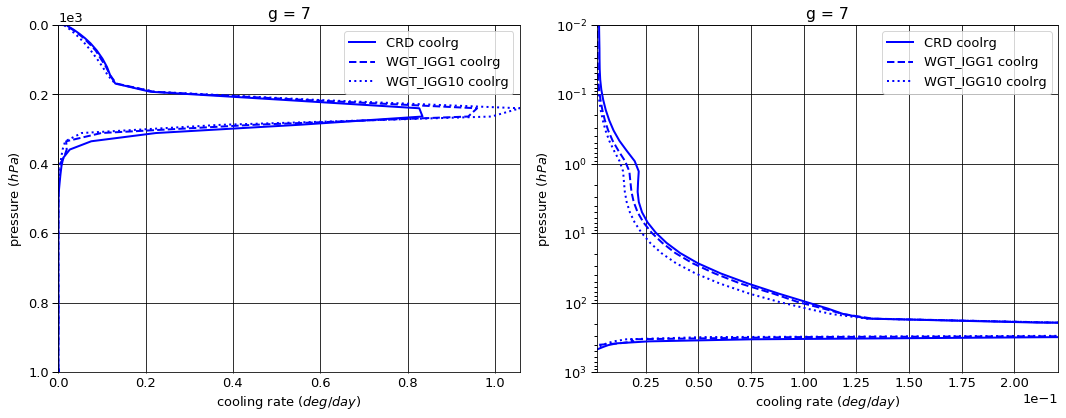

# Figure: cooling rate g-group 8

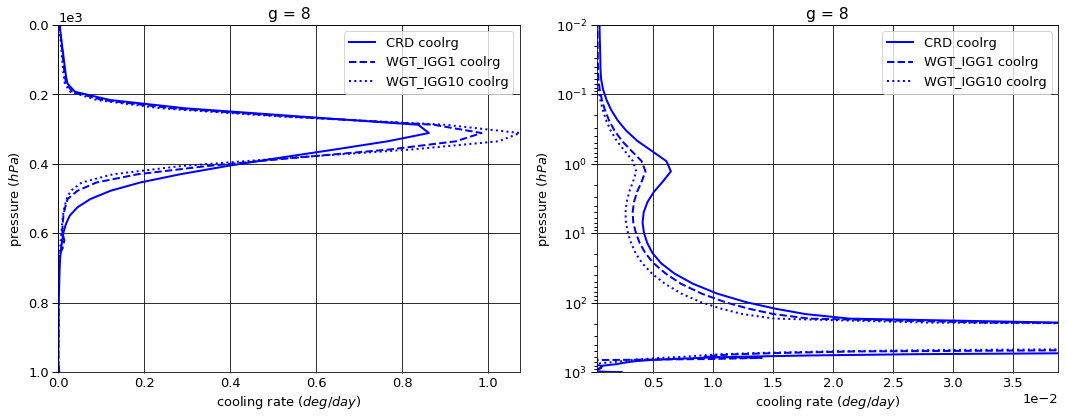

# Figure: cooling rate g-group 9

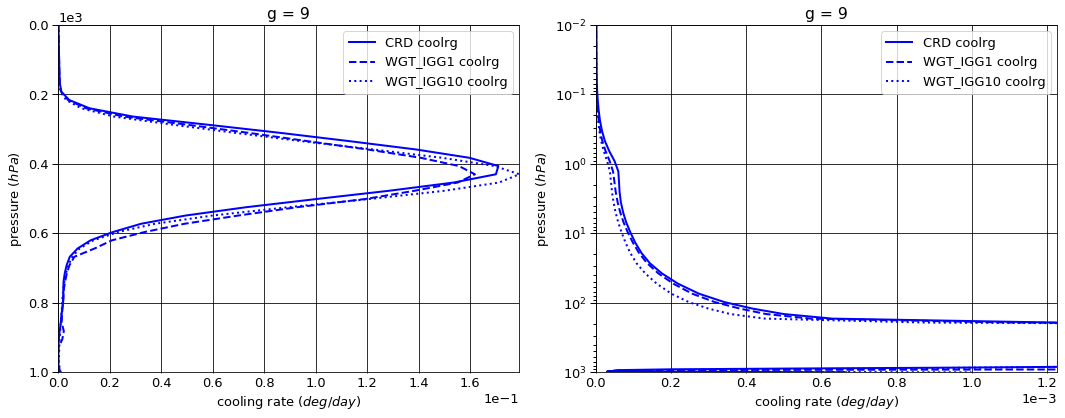

# Figure: cooling rate g-group total

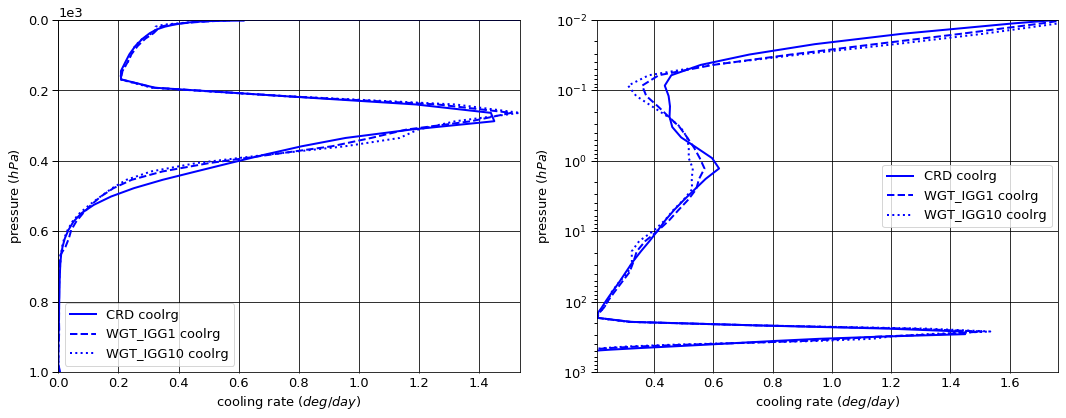

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007551   0.000000  -0.007551
  1013.0   76     -0.012813   0.012810  -0.000003
2 0.0      1      -0.030995   0.000000  -0.030995
  1013.0   76     -0.041548   0.041538  -0.000011
3 0.0      1      -0.107575   0.000000  -0.107575
  1013.0   76     -0.131586   0.131553  -0.000033
4 0.0      1      -0.273071   0.000000  -0.273071
  1013.0   76     -0.371318   0.371226  -0.000092
5 0.0      1      -0.968385   0.000000  -0.968385
  1013.0   76     -1.502007   1.501635  -0.000372
6 0.0      1      -2.820476   0.000000  -2.820476
  1013.0   76     -4.651309   4.650165  -0.001144
7 0.0      1     -11.251404   0.000000 -11.251404
  1013.0   76    -17.534280  17.529920  -0.004360
8 0.0      1     -16.722048   0.000000 -16.722048
  1013.0   76    -24.276329  24.269732  -0.006597
9 0.0      1      -4.359443   0.000000  -4.359443
  1013.0   76     -6.052624   6.050780  -0.001844


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007448   0.000000  -0.007448
  1013.0   76     -0.012813   0.012810  -0.000003
2 0.0      1      -0.031389   0.000000  -0.031389
  1013.0   76     -0.041548   0.041538  -0.000011
3 0.0      1      -0.107711   0.000000  -0.107711
  1013.0   76     -0.131586   0.131553  -0.000033
4 0.0      1      -0.275241   0.000000  -0.275241
  1013.0   76     -0.371318   0.371226  -0.000092
5 0.0      1      -0.966498   0.000000  -0.966498
  1013.0   76     -1.502007   1.501635  -0.000372
6 0.0      1      -2.805936   0.000000  -2.805936
  1013.0   76     -4.651309   4.650165  -0.001144
7 0.0      1     -11.171318   0.000000 -11.171318
  1013.0   76    -17.534280  17.529920  -0.004360
8 0.0      1     -16.576801   0.000000 -16.576801
  1013.0   76    -24.276329  24.269732  -0.006597
9 0.0      1      -4.413088   0.000000  -4.413088
  1013.0   76     -6.052624   6.050804  -0.001820


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007430   0.000000  -0.007430
  1013.0   76     -0.012813   0.012810  -0.000003
2 0.0      1      -0.031390   0.000000  -0.031390
  1013.0   76     -0.041548   0.041538  -0.000011
3 0.0      1      -0.108202   0.000000  -0.108202
  1013.0   76     -0.131586   0.131553  -0.000033
4 0.0      1      -0.275359   0.000000  -0.275359
  1013.0   76     -0.371318   0.371226  -0.000092
5 0.0      1      -0.965377   0.000000  -0.965377
  1013.0   76     -1.502007   1.501635  -0.000372
6 0.0      1      -2.796066   0.000000  -2.796066
  1013.0   76     -4.651309   4.650165  -0.001144
7 0.0      1     -11.158810   0.000000 -11.158810
  1013.0   76    -17.534280  17.529920  -0.004360
8 0.0      1     -16.556669   0.000000 -16.556669
  1013.0   76    -24.276329  24.269732  -0.006597
9 0.0      1      -4.407240   0.000000  -4.407240
  1013.0   76     -6.052624   6.050093  -0.002531


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.030517e-04  0.000000  1.030517e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -3.941710e-04  0.000000 -3.941710e-04
  1013.0   76     0.000000e+00  0.000000 -1.694066e-21
3 0.0      1     -1.360600e-04  0.000000 -1.360600e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1     -2.169660e-03  0.000000 -2.169660e-03
  1013.0   76     0.000000e+00  0.000000  1.355253e-20
5 0.0      1      1.886500e-03  0.000000  1.886500e-03
  1013.0   76     0.000000e+00  0.000000 -5.421011e-20
6 0.0      1      1.453950e-02  0.000000  1.453950e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
7 0.0      1      8.008600e-02  0.000000  8.008600e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
8 0.0      1      1.452470e-01  0.000000  1.452470e-01
  1013.0   76     0.000000e+00  0.000000  6.890000e-08
9 0.0      1     -5.364540e-02  0.000000 -5.364540e-02
  1013.0   76    -8.881784e-16  0.000023  2.349410e-05


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.208649e-04  0.000000  1.208649e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -3.955890e-04  0.000000 -3.955890e-04
  1013.0   76     0.000000e+00  0.000000 -1.694066e-21
3 0.0      1     -6.261700e-04  0.000000 -6.261700e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1     -2.287980e-03  0.000000 -2.287980e-03
  1013.0   76     0.000000e+00  0.000000  1.355253e-20
5 0.0      1      3.007950e-03  0.000000  3.007950e-03
  1013.0   76     0.000000e+00  0.000000 -5.421011e-20
6 0.0      1      2.441020e-02  0.000000  2.441020e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
7 0.0      1      9.259400e-02  0.000000  9.259400e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
8 0.0      1      1.653790e-01  0.000000  1.653790e-01
  1013.0   76     0.000000e+00  0.000000  6.890000e-08
9 0.0      1     -4.779740e-02  0.000000 -4.779740e-02
  1013.0   76    -8.881784e-16 -0.000687 -6.870923e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      4.811306
  1001.112500 75     0.000001
2 0.000312    1      0.356887
  1001.112500 75     0.000004
3 0.000312    1      0.022848
  1001.112500 75     0.000012
4 0.000312    1      0.000011
  1001.112500 75     0.000033
5 0.000312    1      0.000454
  1001.112500 75     0.000135
6 0.000312    1      0.000740
  1001.112500 75     0.000414
7 0.000312    1      0.002660
  1001.112500 75     0.001577
8 0.000312    1      0.000412
  1001.112500 75     0.002385
9 0.000312    1      0.000002
  1001.112500 75     0.000666


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.651525e+00
  1001.112500 75     1.152206e-06
2 0.000312    1      1.706309e-01
  1001.112500 75     3.800091e-06
3 0.000312    1      1.044442e-02
  1001.112500 75     1.192121e-05
4 0.000312    1      1.141639e-05
  1001.112500 75     3.313352e-05
5 0.000312    1      4.103955e-04
  1001.112500 75     1.345275e-04
6 0.000312    1      4.229309e-04
  1001.112500 75     4.138870e-04
7 0.000312    1      1.843297e-03
  1001.112500 75     1.576631e-03
8 0.000312    1      2.742963e-04
  1001.112500 75     2.385208e-03
9 0.000312    1      9.654194e-07
  1001.112500 75     6.578999e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.249421e+00
  1001.112500 75     1.152206e-06
2 0.000312    1      1.298419e-01
  1001.112500 75     3.800091e-06
3 0.000312    1      8.665538e-03
  1001.112500 75     1.192121e-05
4 0.000312    1      1.006982e-05
  1001.112500 75     3.313352e-05
5 0.000312    1      3.575613e-04
  1001.112500 75     1.345275e-04
6 0.000312    1      3.588866e-04
  1001.112500 75     4.138870e-04
7 0.000312    1      1.510737e-03
  1001.112500 75     1.576631e-03
8 0.000312    1      2.192758e-04
  1001.112500 75     2.385208e-03
9 0.000312    1      7.387895e-07
  1001.112500 75     9.988761e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.159781e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.862558e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.240320e-02
  1001.112500 75     0.000000e+00
4 0.000312    1      8.492600e-08
  1001.112500 75     0.000000e+00
5 0.000312    1     -4.354864e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.166285e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -8.162743e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.376946e-04
  1001.112500 75    -2.710000e-08
9 0.000312    1     -5.790330e-07
  1001.112500 75    -8.044220e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.561885e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.270449e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.418208e-02
  1001.112500 75     0.000000e+00
4 0.000312    1     -1.261652e-06
  1001.112500 75     0.000000e+00
5 0.000312    1     -9.638281e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.806728e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -1.148834e-03
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.927151e-04
  1001.112500 75    -2.710000e-08
9 0.000312    1     -8.056629e-07
  1001.112500 75     3.329319e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.540948,0.000000,-36.540948
1013.0,76,-54.573814,54.559359,-0.014455



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.355431,0.000000,-36.355431
1013.0,76,-54.573814,54.559382,-0.014432



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.306543,0.000000,-36.306543
1013.0,76,-54.573814,54.558672,-0.015142



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.855168e-01,0.000000,0.185517
1013.0,76,-7.105427e-15,0.000023,0.000024



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.344049e-01,0.000000,0.234405
1013.0,76,-7.105427e-15,-0.000687,-0.000687


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.195318
1001.112500,75,0.005226



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.835564
1001.112500,75,0.005218



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.390385
1001.112500,75,0.005559



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.359754
1001.112500,75,-0.000008



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.804933
1001.112500,75,0.000333


In [20]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000294,0.000239
2,0.000824,0.000771
3,0.002691,0.002451
4,0.008162,0.006948
5,0.032529,0.028072
6,0.103515,0.087107
7,0.374029,0.327326
8,0.383000,0.440913
9,0.094956,0.106174


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.290914e-20
7,5.055345e-21
8,4.062448e-22
9,1.792420e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000294,0.000239,0.000294,0.000239,1.0
2,5.686282e-18,0.078727,0.000824,0.000771,0.001118,0.001011,1.0
3,4.476633e-19,0.078727,0.002691,0.002451,0.003809,0.003461,1.0
4,1.008726e-18,2.253314,0.008162,0.006948,0.011971,0.010409,30.0
5,8.035412e-20,0.079659,0.032529,0.028072,0.044500,0.038480,30.0
6,6.290914e-20,0.782899,0.103515,0.087107,0.148015,0.125587,300.0
7,5.055345e-21,0.080359,0.374029,0.327326,0.522044,0.452913,300.0
8,4.062448e-22,0.080359,0.383000,0.440913,0.905044,0.893826,300.0
9,1.792420e-23,0.044122,0.094956,0.106174,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.381695e-16  1.079118e-16   3.133758  1.507259e-02
      2 0.000312     8.582950e-18  3.247272e-18   2.643126  4.128591e-04
      3 0.000312     2.466146e-19  7.128305e-20   3.459652  1.054998e-05
      4 0.000312     3.831232e-23  3.831158e-23   1.000019  3.262677e-09
      5 0.000312     3.716482e-22  2.222885e-22   1.671918  2.274624e-08
      6 0.000312     1.500142e-22  4.814781e-23   3.115700  6.702840e-09
      7 0.000312     1.502718e-22  1.468316e-23  10.234294  8.178564e-09
      8 0.000312     2.144483e-23  1.109550e-24  19.327492  1.133556e-09
      9 0.000312     4.359512e-25  5.143036e-26   8.476534  2.402761e-11
2     1 0.000750     3.386803e-16  1.081444e-16   3.131742  6.081882e-03
      2 0.000750     8.629012e-18  3.261296e-18   2.645884  1.671049e-04
      3 0.000750     2.478713e-19  7.208793e-20   3.438457  4.281648e-06
      4 0.000750     9.116819e-23  9.116491e-23   1.000036  3.127152e-09
      5 0.000750     3.783308e-22  2.278861e-22   1.660175  9.365055e-09
      6 0.000750     1.504306e-22  4.861373e-23   3.094405  2.715287e-09
      7 0.000750     1.506562e-22  1.476581e-23  10.203041  3.303262e-09
      8 0.000750     2.157149e-23  1.116874e-24  19.314163  4.592885e-10
      9 0.000750     4.389007e-25  5.195953e-26   8.446973  9.745966e-12
3     1 0.001052     3.397538e-16  1.085284e-16   3.130553  8.557565e-03
      2 0.001052     8.721286e-18  3.281705e-18   2.657547  2.363644e-04
      3 0.001052     2.498366e-19  7.298195e-20   3.423265  6.062989e-06
      4 0.001052     1.276948e-22  1.276886e-22   1.000049  6.142462e-09
      5 0.001052     3.859890e-22  2.332493e-22   1.654835  1.342453e-08
      6 0.001052     1.508766e-22  4.912877e-23   3.071044  3.831659e-09
      7 0.001052     1.514197e-22  1.487705e-23  10.178073  4.656625e-09
      8 0.001052     2.183722e-23  1.126703e-24  19.381521  6.519584e-10
      9 0.001052     4.447328e-25  5.253964e-26   8.464709  1.384709e-11
4     1 0.001476     3.408873e-16  1.089525e-16   3.128769  1.204833e-02
      2 0.001476     8.820685e-18  3.304807e-18   2.669047  3.346974e-04
      3 0.001476     2.520617e-19  7.406432e-20   3.403281  8.601898e-06
      4 0.001476     1.789590e-22  1.789470e-22   1.000067  1.207651e-08
      5 0.001476     3.952710e-22  2.400320e-22   1.646743  1.934150e-08
      6 0.001476     1.514275e-22  4.975668e-23   3.043360  5.416219e-09
      7 0.001476     1.522510e-22  1.500561e-23  10.146275  6.569872e-09
      8 0.001476     2.212335e-23  1.138085e-24  19.439094  9.265202e-10
      9 0.001476     4.510706e-25  5.324751e-26   8.471207  1.970171e-11
5     1 0.002070     3.420194e-16  1.094060e-16   3.126148  1.696102e-02
      2 0.002070     8.922537e-18  3.330406e-18   2.679114  4.740305e-04
      3 0.002070     2.545107e-19  7.536970e-20   3.376831  1.222094e-05
      4 0.002070     2.509040e-22  2.508807e-22   1.000093  2.374748e-08
      5 0.002070     4.064407e-22  2.486209e-22   1.634781  2.801439e-08
      6 0.002070     1.521049e-22  5.051854e-23   3.010872  7.666432e-09
      7 0.002070     1.531132e-22  1.515183e-23  10.105263  9.269319e-09
      8 0.002070     2.241534e-23  1.151062e-24  19.473615  1.316600e-09
      9 0.002070     4.576345e-25  5.410945e-26   8.457570  2.803877e-11
6     1 0.002904     3.431494e-16  1.098999e-16   3.122381  2.388277e-02
      2 0.002904     9.027404e-18  3.359497e-18   2.687130  6.718214e-04
      3 0.002904     2.572612e-19  7.698627e-20   3.341651  1.740259e-05
      4 0.002904     3.518720e-22  3.518267e-22   1.000129  4.671540e-08
      5 0.002904     4.202230e-22  2.597344e-22   1.617895  4.087873e-08
      6 0.002904     1.529574e-22  5.146658e-23   2.971975  1.087606e-08
      7 0.002904     1.540126e-22  1.532258e-23  10.051350  1.308315e-08
      8 0.002904     2.271363e-23  1.166250e-24  19.475789  1.871413e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
